# Cluster BGCs by their domains

Cluster biosynthetic gene clusters by their protein domains, and produce an output that can be loaded into Cytoscape

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
from glob import glob
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from bigscape_wrapper import run_bigscape_hmmscan, get_products
from sklearn.feature_extraction.text import CountVectorizer

from clusterer import DpMixtureGibbs

## 1. Setup

Path to the input and output directories

In [3]:
input_dir = '/Users/joewandy/Dropbox/Meta_clustering/MS2LDA/BGC/scripts/bigscape/input/'
output_dir = '/Users/joewandy/Dropbox/Meta_clustering/MS2LDA/BGC/scripts/bigscape/output/'

In the cell below, specify the paths to:
- Bigscape codes
- The installation location of BioPython in your virtual env (required to run hmmscan etc.)

In [4]:
bigscape_path = '/Users/joewandy/git/BiG-SCAPE/'
biopython_path = '/Users/joewandy/anaconda/envs/bigscape/lib/python2.7/site-packages'

Path to the pfam database that has been processed via *hmmpress*

In [5]:
pfam_dir = '/Users/joewandy/Downloads/pfam/'

In [6]:
def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

## 2. Extract domains using bigscape

Run this to use bigscape to extract the FASTA files, runs hmmscan on them, and generates pfd/pfs files.

Can skip this step if the files already exist!

In [ ]:
base_names = run_bigscape_hmmscan(input_dir, output_dir, pfam_dir, bigscape_path, biopython_path, parallel=True)

## 2. Load domain files

Load the processed domain files produced by bigscape

In [108]:
doc_filenames = set(glob(os.path.join(output_dir, 'pfs', '*.pfs')))
corpus = []
bgc_names = []
for doc_fn in doc_filenames:
    with open(doc_fn, 'r') as f:
        doc_lines = f.readlines()
        doc = ' '.join(doc_lines)
        basename = os.path.splitext(os.path.basename(doc_fn))[0]
        corpus.append(doc)
        bgc_names.append(basename)
bgc_names = np.array(bgc_names)

In [109]:
print bgc_names[0:10]

['KB894848.1.cluster009' 'AXVR01000001.1.cluster003'
 'KB900388.1.cluster027' 'KB896072.1.cluster026' 'KI911412.1.cluster044'
 'KE384268.1.cluster005' 'KB900614.1.cluster026' 'KB897006.1.cluster023'
 'AZWE01000001.1.cluster069' 'CP000850.1.cluster033']


Turn BGCs into a bag-of-word count matrix

In [110]:
vectorizer = CountVectorizer(token_pattern='\w+\.\w+')
counts = vectorizer.fit_transform(corpus).toarray()
print counts.shape

(1615, 1419)


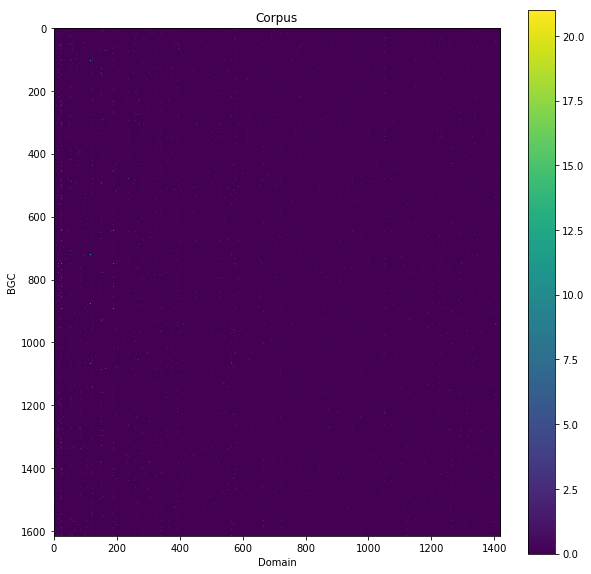

In [265]:
plt.figure(figsize=(10, 10))
plt.imshow(counts, aspect=None)
plt.colorbar()
plt.title('Corpus')
plt.ylabel('BGC')
plt.xlabel('Domain')

In [112]:
vocab = vectorizer.get_feature_names()
print vocab[0:10]

[u'pf00004.28', u'pf00005.26', u'pf00006.24', u'pf00009.26', u'pf00011.20', u'pf00012.19', u'pf00013.28', u'pf00027.28', u'pf00037.26', u'pf00041.20']


Get the mapping between the bgc names, antiSMASH predicted products and Bigscape types (e.g. NRPS, RIPPs, Others, etc)

In [113]:
bigscape_products, antismash_products = get_products(input_dir, bigscape_path, biopython_path)

In [266]:
# for bgc in bgc_names:
#     print bgc, antismash_products[bgc], bigscape_products[bgc]

In [115]:
save_pickle(counts, 'mixture_test/counts.p')
save_pickle(vocab, 'mixture_test/vocab.p')
save_pickle(bigscape_products, 'mixture_test/bigscape_products.p')
save_pickle(antismash_products, 'mixture_test/antismash_products.p')
save_pickle(bgc_names, 'mixture_test/bgc_names.p')

## 3. Run clustering

In [116]:
counts = load_pickle('mixture_test/counts.p')
bigscape_products = load_pickle('mixture_test/bigscape_products.p')
antismash_products = load_pickle('mixture_test/antismash_products.p')
bgc_names = load_pickle('mixture_test/bgc_names.p')

Assign each BGC product type to a number

In [117]:
bgc_types = {}
for i, t in enumerate(sorted(set(bigscape_products.values()))):
    print i, t
    bgc_types[t] = i    
print

bgc_types_arr = []
for bgc_name in bgc_names:
    prod = bigscape_products[bgc_name]
    bgc_type = bgc_types[prod]
    bgc_types_arr.append(bgc_type)
bgc_types_arr = np.array(bgc_types_arr)

0 NRPS
1 Others
2 PKS-NRP_Hybrids
3 PKSI
4 PKSother
5 RiPPs
6 Saccharide
7 Saccharides
8 Terpene



Select the NRPS type BGCs for clustering. First select 'NRPS' and 'PKS-NRP_Hybrids'

In [268]:
idx = np.where(bgc_types_arr == 0) # NRPS
idx = np.append(idx, np.where(bgc_types_arr == 2)) # PKS-NRP_Hybrids
print idx.shape

(110,)


Then select 'Others' but having 'nrps' in the antiSmash products

In [269]:
other_idx = []
for i in np.where(bgc_types_arr == 1)[0]: # Others
    bgc_name = bgc_names[i]
    bigscape_prod = bigscape_products[bgc_name]    
    antismash_prod = antismash_products[bgc_name]  
    if 'nrps' in antismash_prod.lower():
        other_idx.append(i)
        # print bgc_name, bigscape_prod, antismash_prod 
        
idx = np.append(idx, other_idx)
print idx.shape

(159,)


Cluster the NRPS type BGCs

(159, 1419)


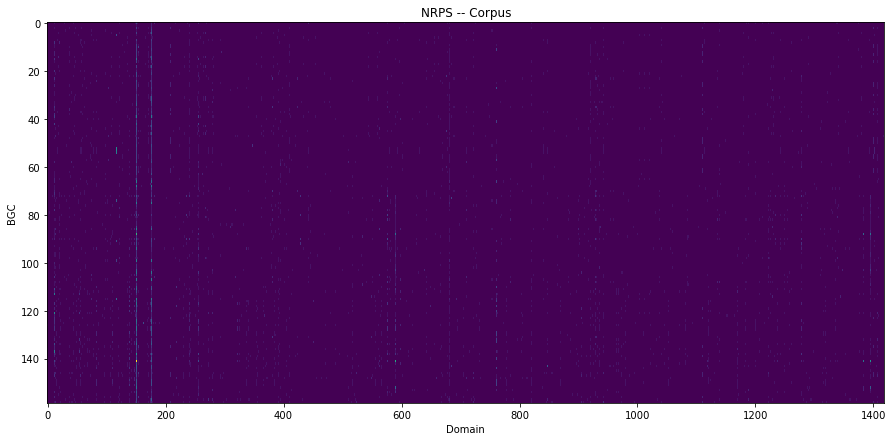

In [270]:
data = counts[idx]
print data.shape

plt.figure(figsize=(15, 7))
plt.imshow(data, aspect='auto', interpolation='nearest')
plt.ylabel('BGC')
plt.xlabel('Domain')
plt.title('NRPS -- Corpus')

In [273]:
alpha = 100      # dp concentration parameter
beta = 0.1       # multinomial parameter
clusterer = DpMixtureGibbs(data, alpha, beta, nsamps=100, burnin=20, seed=123)
clusterer.run()

Sampling begins
	BURN-IN 1	time 0.16	numClusters 4
	BURN-IN 2	time 0.19	numClusters 4
	BURN-IN 3	time 0.19	numClusters 4
	BURN-IN 4	time 0.18	numClusters 4
	BURN-IN 5	time 0.19	numClusters 4
	BURN-IN 6	time 0.19	numClusters 4
	BURN-IN 7	time 0.20	numClusters 5
	BURN-IN 8	time 0.19	numClusters 4
	BURN-IN 9	time 0.19	numClusters 4
	BURN-IN 10	time 0.18	numClusters 4
	BURN-IN 11	time 0.18	numClusters 4
	BURN-IN 12	time 0.18	numClusters 4
	BURN-IN 13	time 0.19	numClusters 4
	BURN-IN 14	time 0.19	numClusters 4
	BURN-IN 15	time 0.18	numClusters 4
	BURN-IN 16	time 0.19	numClusters 4
	BURN-IN 17	time 0.19	numClusters 4
	BURN-IN 18	time 0.20	numClusters 5
	BURN-IN 19	time 0.19	numClusters 4
	BURN-IN 20	time 0.19	numClusters 4
	SAMPLE 21	time 0.19	numClusters 4
	SAMPLE 22	time 0.18	numClusters 4
	SAMPLE 23	time 0.18	numClusters 4
	SAMPLE 24	time 0.19	numClusters 4
	SAMPLE 25	time 0.17	numClusters 4
	SAMPLE 26	time 0.18	numClusters 4
	SAMPLE 27	time 0.18	numClusters 5
	SAMPLE 28	time 0.21	numClus

In [274]:
save_pickle(clusterer, 'mixture_test/clusterer.p')

## 3. Generate output

In [275]:
clusterer = load_pickle('mixture_test/clusterer.p')

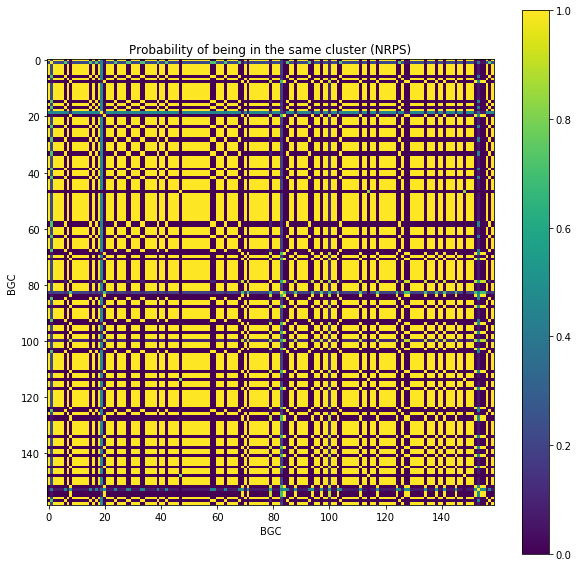

In [276]:
ZZ_all = clusterer.ZZ_all.todense()/clusterer.samples_obtained
plt.figure(figsize=(10, 10))
plt.imshow(ZZ_all)
plt.colorbar()
plt.title('Probability of being in the same cluster (NRPS)')
plt.xlabel('BGC')
plt.ylabel('BGC')

In [277]:
print np.sum(ZZ_all > 0.0)
print np.sum(ZZ_all > 0.5)
print np.sum(ZZ_all > 0.9)

14489
13089
12955


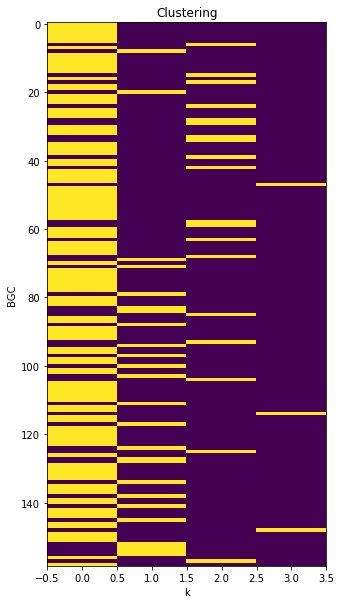

In [278]:
plt.figure(figsize=(5, 10))
plt.imshow(clusterer.Z.todense(), aspect='auto', interpolation='nearest')
plt.title('Clustering')
plt.xlabel('k')
plt.ylabel('BGC')

Compare against current bigscape output